In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

In [2]:
from sqlalchemy import create_engine


driver = 'mysql+pymysql:'
user = 'adria'
password = '00000'
ip = '35.187.114.125'
database = 'vimet'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [3]:
items = pd.read_sql('items', con = engine)

### Create a data frame that contains the total quantity of each product purchased by each order

In [6]:
rec = items.groupby(['Name', 'tags']).sum()[['Lineitem quantity']]

### Create a product by order matrix

In [9]:
df_pivot = rec.pivot_table(index='tags', columns='Name', values='Lineitem quantity').fillna(0)
df_pivot.head()

Name,#1001,#1002,#1003,#1004,#1005,#1006,#1007,#1008,#1009,#1010,...,#1239,#1240,#1241,#1242,#1243,#1244,#1245,#1246,#1247,#1248
tags,,,,,,,,,,,,,,,,,,,,,
Aceite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acelgas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agua,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aguacate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Ajo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Create an order similarity matrix

In [11]:
from scipy.spatial.distance import pdist, squareform
similarity_matrix = squareform(pdist(df_pivot.T, 'euclidean'))
similarity_matrix

array([[0.        , 1.41421356, 1.41421356, ..., 6.32455532, 4.69041576,
        6.08276253],
       [1.41421356, 0.        , 1.41421356, ..., 6.32455532, 4.69041576,
        6.08276253],
       [1.41421356, 1.41421356, 0.        , ..., 6.4807407 , 4.89897949,
        6.08276253],
       ...,
       [6.32455532, 6.32455532, 6.4807407 , ..., 0.        , 6.32455532,
        6.8556546 ],
       [4.69041576, 4.69041576, 4.89897949, ..., 6.32455532, 0.        ,
        6.244998  ],
       [6.08276253, 6.08276253, 6.08276253, ..., 6.8556546 , 6.244998  ,
        0.        ]])

### Top 5 most similar orders for a specific order.

In [12]:
similarity_df = pd.DataFrame(similarity_matrix, index=df_pivot.columns, columns=df_pivot.columns)

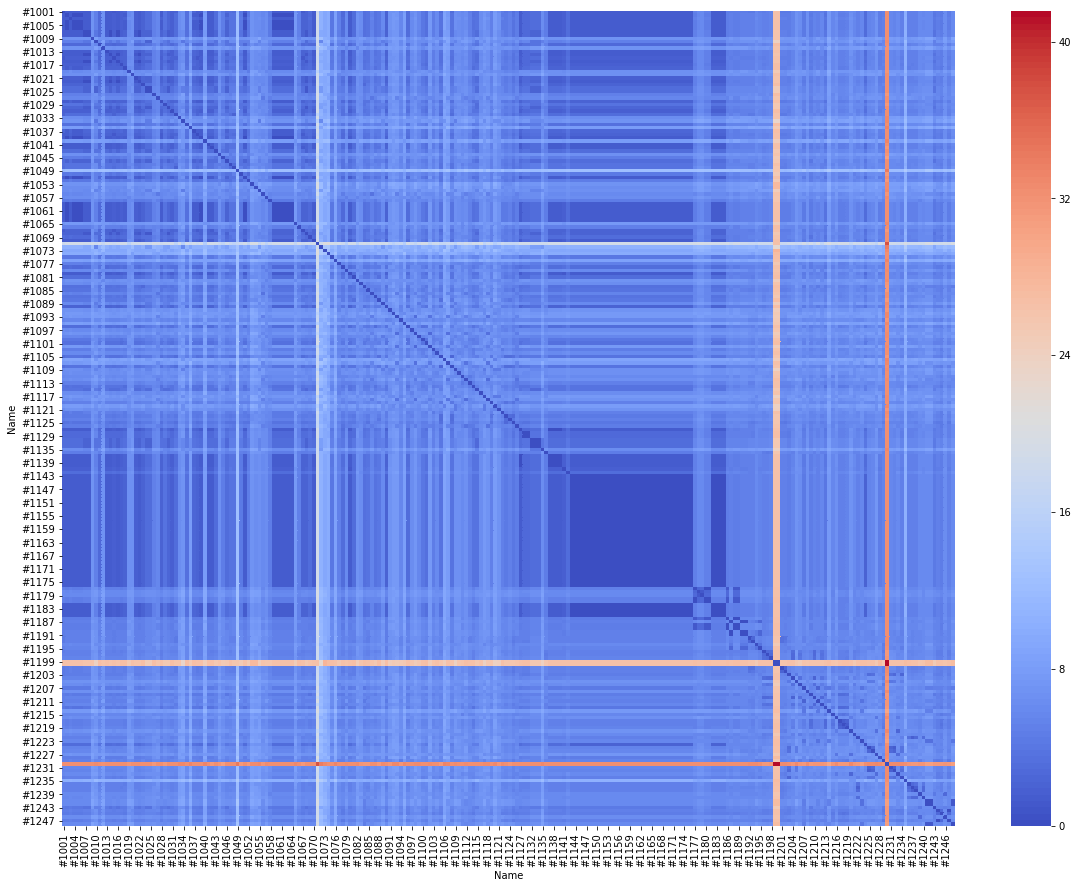

In [15]:
plt.figure(figsize=(20,15))
cmap = sns.color_palette("coolwarm", 128)
sns.heatmap(similarity_df, cmap=cmap)

plt.show()

In [ ]:
# No entiendo porque salen líneas (i.e. constantes para todos los orders...)